# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
# sns.set_context("talk")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_test:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

assert out.shape == correct_out.shape

Testing affine_forward function:
difference:  9.76985004799e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

assert dx.shape == dx.shape
assert dw.shape == dw.shape
assert db.shape == db.shape

Testing affine_backward function:
dx error:  4.03641105847e-09
dw error:  9.08748060543e-11
db error:  1.18003341218e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

assert out.shape == correct_out.shape

#better check
x = np.random.randn(5,5)
out1 , _ = relu_forward(x)
x[x<0] = 0
print(out1 -x)
np.linalg.norm(out1 - x)

for x in range(1,8):
    testing_shape = []
    for y in range(1,x+1):
        testing_shape.append(np.random.randint(3,8))
    shape = tuple(testing_shape)
    #y = np.random.randn(*testing_shape)
    x = np.random.standard_normal(shape)
    assert x.shape == relu_forward(x)[0].shape
    x[x<0] = 0
    print(x.shape)
    print(np.linalg.norm(x - relu_forward(x)[0]))

Testing relu_forward function:
difference:  4.99999979802e-08
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
(5,)
0.0
(4, 3)
0.0
(6, 4, 3)
0.0
(7, 7, 5, 6)
0.0
(4, 6, 3, 5, 3)
0.0
(5, 5, 7, 4, 3, 4)
0.0
(6, 5, 4, 4, 6, 6, 7)
0.0


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

assert dx.shape == dx_num.shape
assert dout.shape == x.shape

Testing relu_backward function:
dx error:  3.27561135152e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)

b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

assert dx.shape == dx_num.shape
assert dw.shape == dw_num.shape
assert db.shape == db_num.shape

assert out.shape == dout.shape

Testing affine_relu_forward:
dx error:  1.09683052418e-10
dw error:  4.31991332578e-10
db error:  3.27561040589e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

assert dx.shape == dx_num.shape
assert y.shape[0] == dx.shape[0]

Testing svm_loss:
loss:  9.00099112424
dx error:  3.0387355051e-09

Testing softmax_loss:
loss:  2.30268461872
dx error:  9.66640357049e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()

assert scores.shape == correct_scores.shape
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
        assert grad_num.shape == grads[name].shape
        assert grads[name].shape == model.params[name].shape

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.50e-10
b1 relative error: 6.55e-09
b2 relative error: 5.96e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.35e-08
b2 relative error: 1.97e-09


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet(input_dim=3*32*32, hidden_dim=256, num_classes=10, weight_scale=0.001)
solver = Solver(model=model, data=data,
                update_rule='sgd', optim_config={'learning_rate' : 1e-3}, lr_decay=0.90, 
                num_epochs=10, batch_size=200,
                print_every=100, verbose=True)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver.train()
solver.optim_config['learning_rate'] = 1e-4
solver.lr_decay = 0.95
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 2450) loss: 2.301331
(Epoch 0 / 10) train acc: 0.151000; val_acc: 0.146000
(Iteration 101 / 2450) loss: 1.772914
(Iteration 201 / 2450) loss: 1.617194
(Epoch 1 / 10) train acc: 0.461000; val_acc: 0.440000
(Iteration 301 / 2450) loss: 1.542776
(Iteration 401 / 2450) loss: 1.471289
(Epoch 2 / 10) train acc: 0.502000; val_acc: 0.452000
(Iteration 501 / 2450) loss: 1.484793
(Iteration 601 / 2450) loss: 1.366722
(Iteration 701 / 2450) loss: 1.402796
(Epoch 3 / 10) train acc: 0.533000; val_acc: 0.478000
(Iteration 801 / 2450) loss: 1.348370
(Iteration 901 / 2450) loss: 1.263963
(Epoch 4 / 10) train acc: 0.523000; val_acc: 0.489000
(Iteration 1001 / 2450) loss: 1.214083
(Iteration 1101 / 2450) loss: 1.333028
(Iteration 1201 / 2450) loss: 1.288534
(Epoch 5 / 10) train acc: 0.579000; val_acc: 0.496000
(Iteration 1301 / 2450) loss: 1.164833
(Iteration 1401 / 2450) loss: 1.319467
(Epoch 6 / 10) train acc: 0.572000; val_acc: 0.496000
(Iteration 1501 / 2450) loss: 1.196639
(Iteration

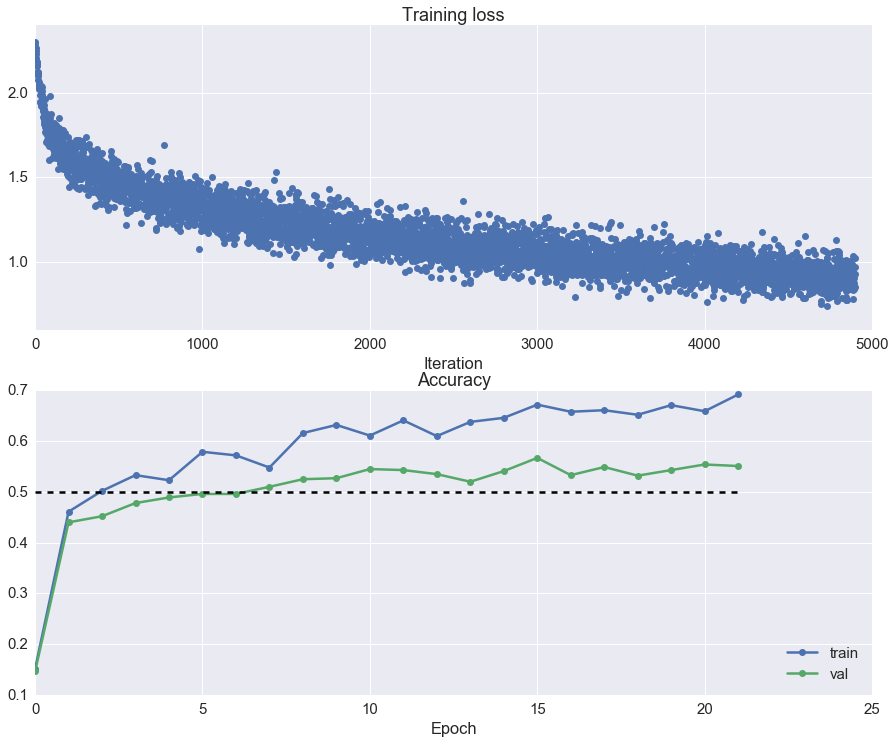

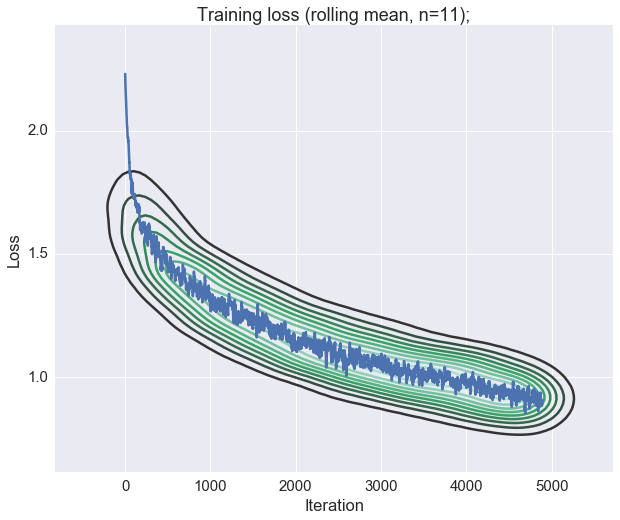

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

#
#d = {'iteration' : x, 'loss' : y}

x = np.arange(len(solver.loss_history))
y = np.array(solver.loss_history)
x_s = pd.Series(x, name='iteration')
y_s = pd.Series(y, name='loss')
df = pd.concat([x_s,y_s], axis=1)

df_mean = df.rolling(window=11,center=True).mean()
df_mean = df_mean.dropna(how='all')

plt.figure()
x = np.arange(len(solver.loss_history))
y = np.array(solver.loss_history)
sns.kdeplot(data=x, data2=y)
y_rolling = df_mean['loss'].values
plt.plot(y_rolling)
plt.title('Training loss (rolling mean, n=11);')
plt.xlabel('Iteration')
plt.ylabel('Loss')



# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.31518498811
('W', 0) relative error: 2.78e-07
('W', 1) relative error: 3.78e-06
('W', 2) relative error: 4.49e-08
('b', 0) relative error: 1.07e-08
('b', 1) relative error: 2.19e-09
('b', 2) relative error: 1.18e-10
Running check with reg =  3.14
Initial loss:  7.12673422398
('W', 0) relative error: 9.34e-08
('W', 1) relative error: 2.53e-07
('W', 2) relative error: 4.28e-08
('b', 0) relative error: 9.04e-08
('b', 1) relative error: 7.88e-02
('b', 2) relative error: 1.65e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 33.024271
(Epoch 0 / 20) train acc: 0.360000; val_acc: 0.130000
(Epoch 1 / 20) train acc: 0.400000; val_acc: 0.142000
(Epoch 2 / 20) train acc: 0.660000; val_acc: 0.156000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.135000
(Epoch 4 / 20) train acc: 0.820000; val_acc: 0.117000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.117000
(Iteration 11 / 40) loss: 4.337039
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.133000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.134000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.135000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.128000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.136000
(Iteration 21 / 40) loss: 1.478578
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.141000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.146000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.140000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.140000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.140000
(Iteration 31 / 40) loss:

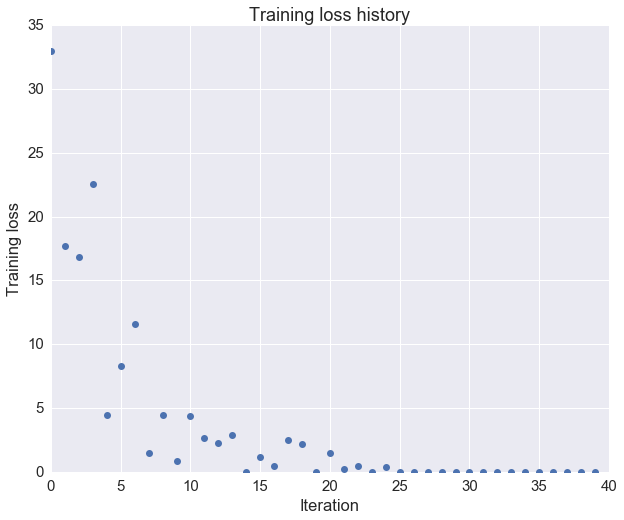

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 31.649795
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.127000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.092000
(Epoch 2 / 20) train acc: 0.280000; val_acc: 0.110000
(Epoch 3 / 20) train acc: 0.620000; val_acc: 0.097000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.086000
(Epoch 5 / 20) train acc: 0.860000; val_acc: 0.086000
(Iteration 11 / 40) loss: 0.773471
(Epoch 6 / 20) train acc: 0.920000; val_acc: 0.099000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.086000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.092000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.089000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.087000
(Iteration 21 / 40) loss: 0.000272
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.088000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.088000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.088000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.088000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.087000
(Iteration 31 / 40) loss:

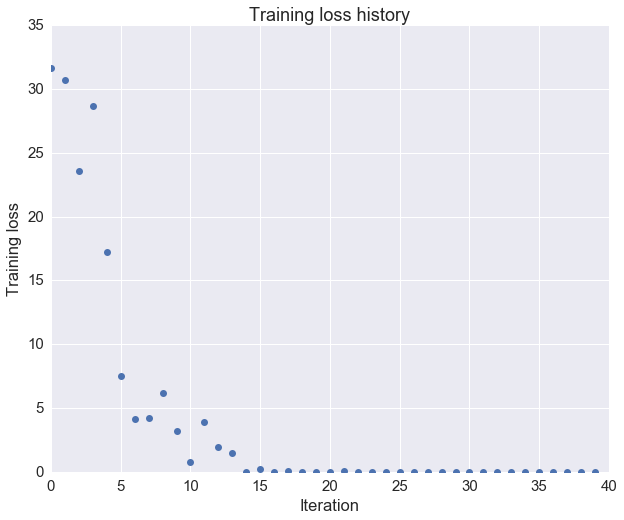

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
The higher the number of layers the less number of iterations it required to overfit.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

assert next_w.shape == expected_next_w.shape

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 800) loss: 2.631438
(Epoch 0 / 20) train acc: 0.096000; val_acc: 0.095000
(Epoch 1 / 20) train acc: 0.128000; val_acc: 0.090000
(Epoch 2 / 20) train acc: 0.118000; val_acc: 0.093000
(Iteration 101 / 800) loss: 2.296150
(Epoch 3 / 20) train acc: 0.122000; val_acc: 0.108000
(Epoch 4 / 20) train acc: 0.132000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.142000; val_acc: 0.116000
(Iteration 201 / 800) loss: 2.287705
(Epoch 6 / 20) train acc: 0.153000; val_acc: 0.128000
(Epoch 7 / 20) train acc: 0.133000; val_acc: 0.139000
(Iteration 301 / 800) loss: 2.292704
(Epoch 8 / 20) train acc: 0.146000; val_acc: 0.150000
(Epoch 9 / 20) train acc: 0.140000; val_acc: 0.152000
(Epoch 10 / 20) train acc: 0.147000; val_acc: 0.155000
(Iteration 401 / 800) loss: 2.271827
(Epoch 11 / 20) train acc: 0.155000; val_acc: 0.161000
(Epoch 12 / 20) train acc: 0.170000; val_acc: 0.169000
(Iteration 501 / 800) loss: 2.249009
(Epoch 13 / 20) train acc: 0.152000; val_acc: 0.173000
(E

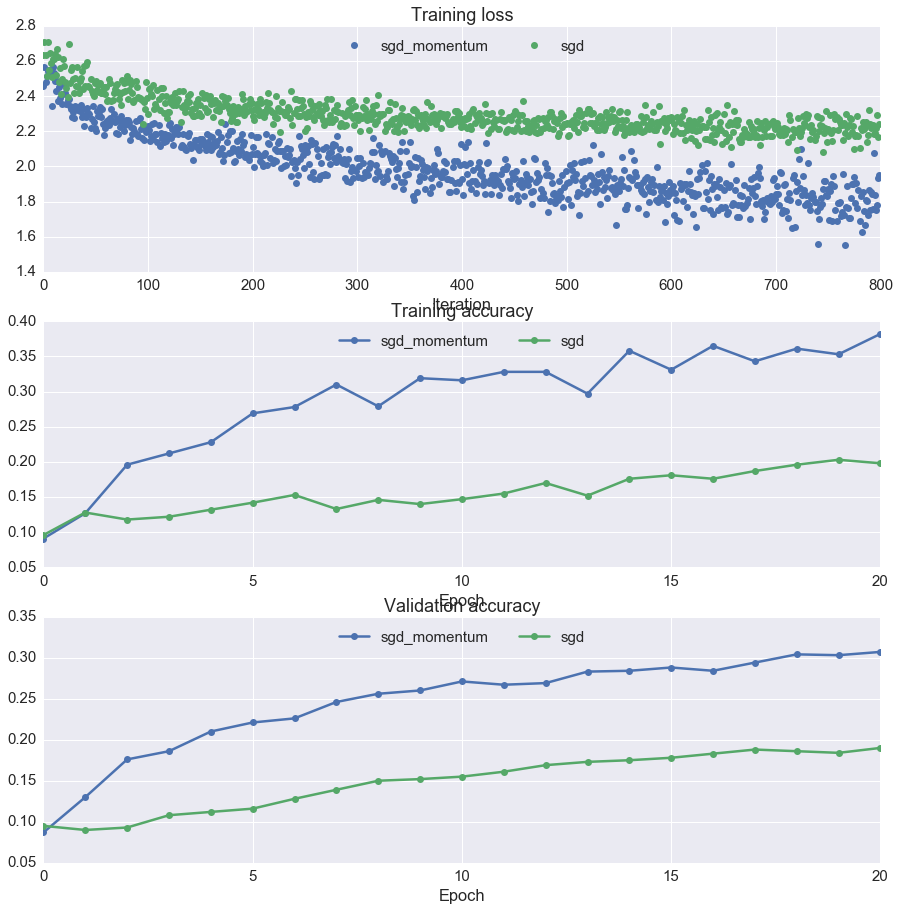

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-4,
                  },
                  print_every=100,
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

running with  adawindow
(Iteration 1 / 800) loss: 2.698778
(Epoch 0 / 20) train acc: 0.102000; val_acc: 0.128000
(Iteration 21 / 800) loss: 2.147400
(Epoch 1 / 20) train acc: 0.216000; val_acc: 0.202000
(Iteration 41 / 800) loss: 2.255882
(Iteration 61 / 800) loss: 2.177452
(Epoch 2 / 20) train acc: 0.243000; val_acc: 0.235000
(Iteration 81 / 800) loss: 2.056181
(Iteration 101 / 800) loss: 2.116209
(Epoch 3 / 20) train acc: 0.264000; val_acc: 0.250000
(Iteration 121 / 800) loss: 1.979766
(Iteration 141 / 800) loss: 1.933171
(Epoch 4 / 20) train acc: 0.279000; val_acc: 0.256000
(Iteration 161 / 800) loss: 1.879695
(Iteration 181 / 800) loss: 1.956016
(Epoch 5 / 20) train acc: 0.307000; val_acc: 0.281000
(Iteration 201 / 800) loss: 1.956342
(Iteration 221 / 800) loss: 2.074434
(Epoch 6 / 20) train acc: 0.301000; val_acc: 0.299000
(Iteration 241 / 800) loss: 1.829037
(Iteration 261 / 800) loss: 1.864438
(Epoch 7 / 20) train acc: 0.360000; val_acc: 0.295000
(Iteration 281 / 800) loss: 1.94

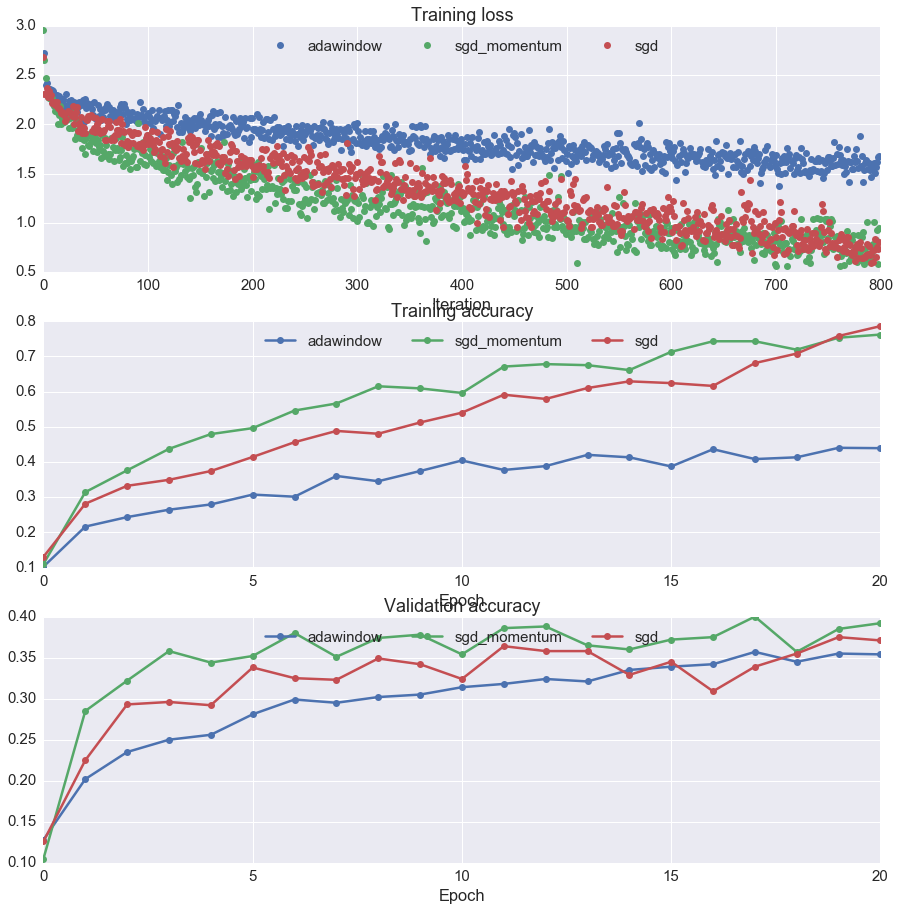

In [17]:
#TESTING Adawindow (keeps a rolling window of 100 gradients); very slow;
from cs231n.optim import adawindow

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

learning_rates = {'sgd_momentum': 1e-2, 'adawindow': 0.01, 'sgd' : 0.01}

for update_rule in [ 'adawindow', 'sgd_momentum', 'sgd']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, reg=0.0)

    solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule],
                  },
                  print_every=20,
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [18]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

assert expected_next_w.shape == w.shape
assert expected_cache.shape == config['cache'].shape

next_w error:  9.50264522989e-08
cache error:  2.64779558072e-09


In [19]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

assert expected_next_w.shape == w.shape
assert expected_v.shape == v.shape
assert expected_m.shape == m.shape

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 800) loss: 2.899630
(Epoch 0 / 20) train acc: 0.106000; val_acc: 0.091000
(Epoch 1 / 20) train acc: 0.232000; val_acc: 0.246000
(Epoch 2 / 20) train acc: 0.338000; val_acc: 0.285000
(Iteration 101 / 800) loss: 1.846429
(Epoch 3 / 20) train acc: 0.392000; val_acc: 0.322000
(Epoch 4 / 20) train acc: 0.418000; val_acc: 0.342000
(Epoch 5 / 20) train acc: 0.477000; val_acc: 0.326000
(Iteration 201 / 800) loss: 1.658610
(Epoch 6 / 20) train acc: 0.480000; val_acc: 0.349000
(Epoch 7 / 20) train acc: 0.523000; val_acc: 0.367000
(Iteration 301 / 800) loss: 1.274432
(Epoch 8 / 20) train acc: 0.565000; val_acc: 0.382000
(Epoch 9 / 20) train acc: 0.596000; val_acc: 0.379000
(Epoch 10 / 20) train acc: 0.616000; val_acc: 0.383000
(Iteration 401 / 800) loss: 1.223369
(Epoch 11 / 20) train acc: 0.634000; val_acc: 0.382000
(Epoch 12 / 20) train acc: 0.670000; val_acc: 0.370000
(Iteration 501 / 800) loss: 1.056082
(Epoch 13 / 20) train acc: 0.682000; val_acc: 0.384000
(

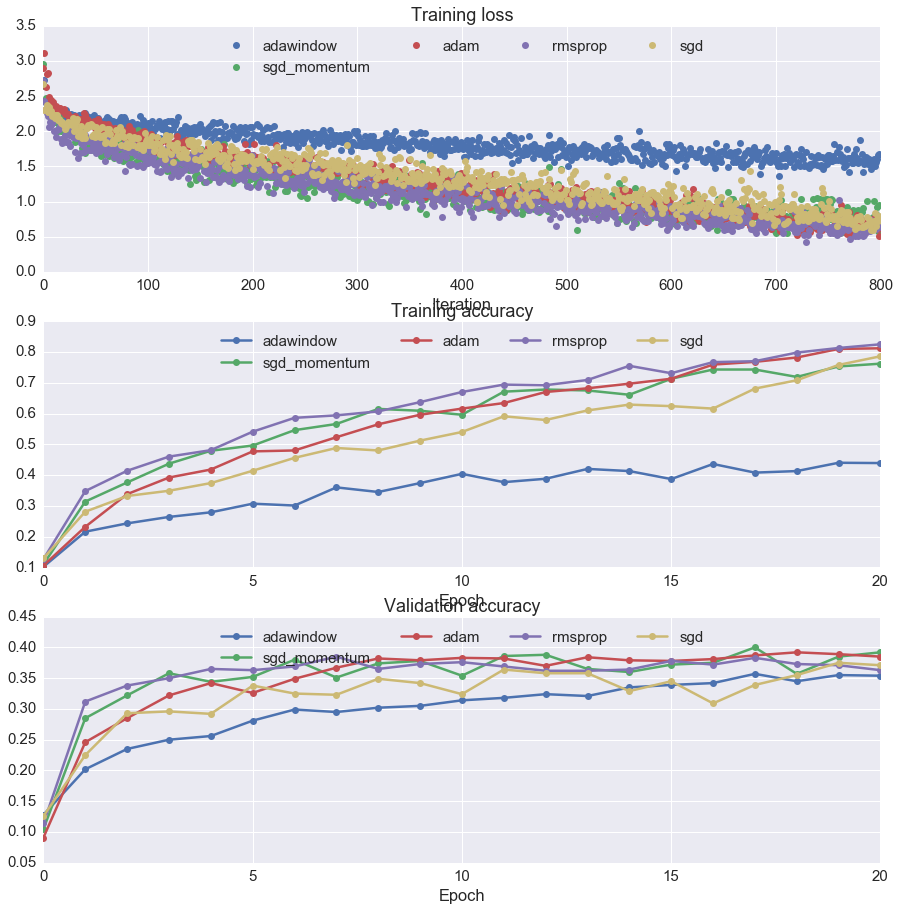

In [20]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-4}

for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)
    
    solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  print_every=100,
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

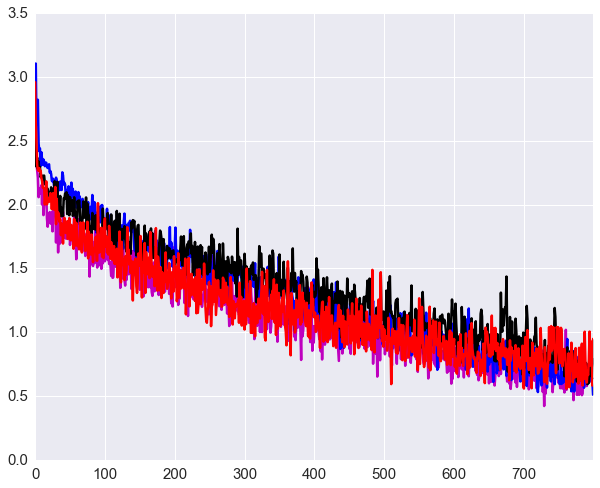

In [21]:
import seaborn as sns

y = np.array(solvers['rmsprop'].loss_history)
z = np.array(solvers['adam'].loss_history)
s = np.array(solvers['sgd'].loss_history)
s_m = np.array(solvers['sgd_momentum'].loss_history)
ax = sns.tsplot(data=y, ci=[68, 95], color="m")
sns.tsplot(data=z, ci=[68, 95], color="b", ax=ax)
sns.tsplot(data=s, ci=[68, 95], color="k", ax=ax)
sns.tsplot(data=s_m, ci=[68, 95], color="r", ax=ax)


In [22]:
solvers_multi = {}
learning_rates = {'rmsprop':1e-4, 'adam': 1e-4, 'sgd_momentum': 1e-4}
for i in range(0,15):
    for update_rule in ['rmsprop', 'sgd_momentum', 'adam']:
        if i == 0:
            solvers_multi[update_rule] = []
        print('running with ', update_rule)
        model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, seed=i)

        solver = Solver(model, small_data,
                        num_epochs=25, batch_size=100,
                        update_rule=update_rule,
                        optim_config={
                          'learning_rate': learning_rates[update_rule]
                        },
                        print_every=100,
                        verbose=True)
        solvers_multi[update_rule].append(solver)
        solver.train()
        print("Done Training ",i)


running with  rmsprop
(Iteration 1 / 1000) loss: 2.971107
(Epoch 0 / 25) train acc: 0.146000; val_acc: 0.126000
(Epoch 1 / 25) train acc: 0.346000; val_acc: 0.323000
(Epoch 2 / 25) train acc: 0.414000; val_acc: 0.330000
(Iteration 101 / 1000) loss: 1.734641
(Epoch 3 / 25) train acc: 0.459000; val_acc: 0.347000
(Epoch 4 / 25) train acc: 0.502000; val_acc: 0.357000
(Epoch 5 / 25) train acc: 0.542000; val_acc: 0.363000
(Iteration 201 / 1000) loss: 1.269216
(Epoch 6 / 25) train acc: 0.572000; val_acc: 0.369000
(Epoch 7 / 25) train acc: 0.579000; val_acc: 0.382000
(Iteration 301 / 1000) loss: 1.154962
(Epoch 8 / 25) train acc: 0.612000; val_acc: 0.365000
(Epoch 9 / 25) train acc: 0.634000; val_acc: 0.381000
(Epoch 10 / 25) train acc: 0.659000; val_acc: 0.387000
(Iteration 401 / 1000) loss: 0.886811
(Epoch 11 / 25) train acc: 0.685000; val_acc: 0.382000
(Epoch 12 / 25) train acc: 0.706000; val_acc: 0.373000
(Iteration 501 / 1000) loss: 0.934155
(Epoch 13 / 25) train acc: 0.686000; val_acc: 0

[(1.5, 3.5), (0, 25)]

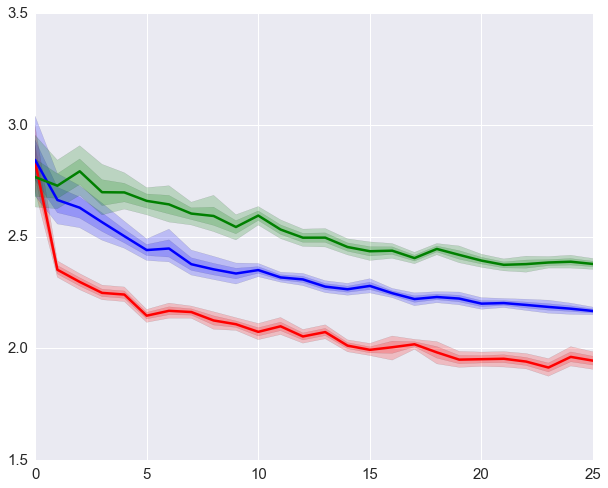

In [23]:
y = []
z = []
s = []

for solver in solvers_multi['rmsprop']:
    y.append(solver.loss_history)
for solver in solvers_multi['adam']:
    z.append(solver.loss_history)
for solver in solvers_multi['sgd_momentum']:
    s.append(solver.loss_history)

rms_loss_array = np.array(y)
adam_loss_array = np.array(z)
sgd_mom_loss_array = np.array(s)

ax = sns.tsplot(data=rms_loss_array, interpolate=True, color="r", ci=[68,95])
sns.tsplot(data=adam_loss_array, interpolate=True, color="b", ci=[68,95])
sns.tsplot(data=sgd_mom_loss_array, interpolate=True, color="g", ci=[68,95])
ax.set(xlim=(0, 25), ylim=(1.5, 3.5))

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [24]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
model = FullyConnectedNet([512, 256], input_dim=3*32*32, num_classes=10,
                            reg=0, weight_scale=5e-4, dropout = 0.75, dtype=np.float32, use_batchnorm=True)

solver = Solver(model=model, data=data,
                update_rule='adam', optim_config={'learning_rate' : 1e-2}, lr_decay=0.90, 
                num_epochs=20, batch_size=1000,
                print_every=25, verbose=True)

solver.train()
solver.optim_config['learning_rate'] = 1e-4
solver.lr_decay = 0.95
solver.train()
solver.optim_config['learning_rate'] = 1e-5
solver.lr_decay = 0.95
solver.train()
solver.optim_config['learning_rate'] = 1e-6
solver.lr_decay = 0.95
solver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 980) loss: 2.302385
(Epoch 0 / 20) train acc: 0.102000; val_acc: 0.122000
(Iteration 26 / 980) loss: 1.766747
(Epoch 1 / 20) train acc: 0.425000; val_acc: 0.448000
(Iteration 51 / 980) loss: 1.659399
(Iteration 76 / 980) loss: 1.544236
(Epoch 2 / 20) train acc: 0.493000; val_acc: 0.488000
(Iteration 101 / 980) loss: 1.508459
(Iteration 126 / 980) loss: 1.373585
(Epoch 3 / 20) train acc: 0.515000; val_acc: 0.507000
(Iteration 151 / 980) loss: 1.355127
(Iteration 176 / 980) loss: 1.354771
(Epoch 4 / 20) train acc: 0.563000; val_acc: 0.510000
(Iteration 201 / 980) loss: 1.329253
(Iteration 226 / 980) loss: 1.250308
(Epoch 5 / 20) train acc: 0.598000; val_acc: 0.528000
(Iteration 251 / 980) loss: 1.240794
(Iteration 276 / 980) loss: 1.244323
(Epoch 6 / 20) train acc: 0.586000; val_acc: 0.549000
(Iteration 301 / 980) loss: 1.297180
(Iteration 326 / 980) loss: 1.129413
(Epoch 7 / 20) train acc: 0.640000; val_acc: 0.546000
(Iteration 351 / 980) loss: 1.148301
(Iteration 376 / 9

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [25]:
solver.batch_size = 5000
solver.optim_config['learning_rate'] = 1e-4
model.dropout = 0.50
solver.lr_decay = 0.99
num_epochs=20
solver.train()

(Iteration 1 / 180) loss: 0.671815
(Epoch 80 / 20) train acc: 0.822000; val_acc: 0.579000
(Epoch 81 / 20) train acc: 0.827000; val_acc: 0.578000
(Epoch 82 / 20) train acc: 0.836000; val_acc: 0.575000
(Iteration 26 / 180) loss: 0.650433
(Epoch 83 / 20) train acc: 0.817000; val_acc: 0.574000
(Epoch 84 / 20) train acc: 0.830000; val_acc: 0.573000
(Epoch 85 / 20) train acc: 0.840000; val_acc: 0.573000
(Iteration 51 / 180) loss: 0.633304
(Epoch 86 / 20) train acc: 0.828000; val_acc: 0.572000
(Epoch 87 / 20) train acc: 0.815000; val_acc: 0.572000
(Epoch 88 / 20) train acc: 0.852000; val_acc: 0.571000
(Iteration 76 / 180) loss: 0.636212
(Epoch 89 / 20) train acc: 0.825000; val_acc: 0.571000
(Epoch 90 / 20) train acc: 0.843000; val_acc: 0.570000
(Epoch 91 / 20) train acc: 0.840000; val_acc: 0.571000
(Iteration 101 / 180) loss: 0.670237
(Epoch 92 / 20) train acc: 0.837000; val_acc: 0.572000
(Epoch 93 / 20) train acc: 0.817000; val_acc: 0.574000
(Iteration 126 / 180) loss: 0.641547
(Epoch 94 / 2

In [26]:
solver.batch_size = 500
solver.optim_config['learning_rate'] = 1e-4
solver.lr_decay = 0.90
model.dropout = 0.25
solver.num_epochs=20
solver.train()

(Iteration 1 / 1960) loss: 0.708445
(Epoch 100 / 20) train acc: 0.838000; val_acc: 0.570000
(Iteration 26 / 1960) loss: 0.656042
(Iteration 51 / 1960) loss: 0.631837
(Iteration 76 / 1960) loss: 0.700203
(Epoch 101 / 20) train acc: 0.821000; val_acc: 0.574000
(Iteration 101 / 1960) loss: 0.619914
(Iteration 126 / 1960) loss: 0.735727
(Iteration 151 / 1960) loss: 0.675817
(Iteration 176 / 1960) loss: 0.678781
(Epoch 102 / 20) train acc: 0.834000; val_acc: 0.575000
(Iteration 201 / 1960) loss: 0.724207
(Iteration 226 / 1960) loss: 0.635503
(Iteration 251 / 1960) loss: 0.701242
(Iteration 276 / 1960) loss: 0.663929
(Epoch 103 / 20) train acc: 0.837000; val_acc: 0.571000
(Iteration 301 / 1960) loss: 0.662002
(Iteration 326 / 1960) loss: 0.678753
(Iteration 351 / 1960) loss: 0.700584
(Iteration 376 / 1960) loss: 0.731068
(Epoch 104 / 20) train acc: 0.841000; val_acc: 0.573000
(Iteration 401 / 1960) loss: 0.765518
(Iteration 426 / 1960) loss: 0.675698
(Iteration 451 / 1960) loss: 0.658768
(It

In [27]:
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.603
Test set accuracy:  0.588


In [28]:
solver.batch_size = 300
solver.optim_config['learning_rate'] = 1e-2
solver.train()

(Iteration 1 / 3260) loss: 0.635782
(Epoch 120 / 20) train acc: 0.839000; val_acc: 0.568000
(Iteration 26 / 3260) loss: 0.581291
(Iteration 51 / 3260) loss: 0.697580
(Iteration 76 / 3260) loss: 0.578872
(Iteration 101 / 3260) loss: 0.619319
(Iteration 126 / 3260) loss: 0.639214
(Iteration 151 / 3260) loss: 0.666331
(Epoch 121 / 20) train acc: 0.835000; val_acc: 0.568000
(Iteration 176 / 3260) loss: 0.796015
(Iteration 201 / 3260) loss: 0.770530
(Iteration 226 / 3260) loss: 0.663874
(Iteration 251 / 3260) loss: 0.744052
(Iteration 276 / 3260) loss: 0.624837
(Iteration 301 / 3260) loss: 0.686647
(Iteration 326 / 3260) loss: 0.629232
(Epoch 122 / 20) train acc: 0.836000; val_acc: 0.568000
(Iteration 351 / 3260) loss: 0.634311
(Iteration 376 / 3260) loss: 0.710248
(Iteration 401 / 3260) loss: 0.647576
(Iteration 426 / 3260) loss: 0.696940
(Iteration 451 / 3260) loss: 0.654574
(Iteration 476 / 3260) loss: 0.625277
(Epoch 123 / 20) train acc: 0.854000; val_acc: 0.569000
(Iteration 501 / 3260

In [29]:
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.602
Test set accuracy:  0.588


In [30]:
model.params[('W',0)]

array([[-0.15959566, -0.22961565,  0.04627275, ...,  0.21012747,
        -0.17238619,  0.05012237],
       [ 0.06554847, -0.41513389,  0.01693868, ...,  0.04289743,
        -0.10827133, -0.03217062],
       [ 0.22185621, -0.30130132, -0.00432344, ..., -0.11279599,
        -0.11510811, -0.08648587],
       ..., 
       [ 0.20229798, -0.25240714,  0.16027648, ...,  0.48235163,
        -0.1701514 ,  0.00176502],
       [ 0.21260481, -0.27713688,  0.08490406, ...,  0.40102147,
        -0.17990193, -0.01628418],
       [ 0.26496547, -0.26023569,  0.0188239 , ...,  0.23616724,
        -0.11818922, -0.04207856]])

In [31]:
model_2 = FullyConnectedNet([512, 256, 128], input_dim=3*32*32, num_classes=10,
                            reg=0, weight_scale=5e-1, dropout = 0.5, dtype=np.float32, use_batchnorm=True)
model_2.params[('W',0)] = np.copy(model.params[('W',0)])
model_2.params[('b',0)] = np.copy(model.params[('b',0)])

solver = Solver(model=model_2, data=data,
                update_rule='adam', optim_config={'learning_rate' : 1e-2}, lr_decay=0.90, 
                num_epochs=20, batch_size=1000,
                print_every=25, verbose=True)
solver.train()
solver.optim_config['learning_rate'] = 1e-2
solver.train()
solver.optim_config['learning_rate'] = 1e-3
solver.train()
solver.optim_config['learning_rate'] = 1e-4
solver.train()

(Iteration 1 / 980) loss: 9.445429
(Epoch 0 / 20) train acc: 0.179000; val_acc: 0.197000
(Iteration 26 / 980) loss: 3.339966
(Epoch 1 / 20) train acc: 0.422000; val_acc: 0.386000
(Iteration 51 / 980) loss: 2.269622
(Iteration 76 / 980) loss: 2.094292
(Epoch 2 / 20) train acc: 0.385000; val_acc: 0.387000
(Iteration 101 / 980) loss: 1.915773
(Iteration 126 / 980) loss: 1.822838
(Epoch 3 / 20) train acc: 0.430000; val_acc: 0.400000
(Iteration 151 / 980) loss: 1.864738
(Iteration 176 / 980) loss: 1.807890
(Epoch 4 / 20) train acc: 0.443000; val_acc: 0.430000
(Iteration 201 / 980) loss: 1.794675
(Iteration 226 / 980) loss: 1.732426
(Epoch 5 / 20) train acc: 0.452000; val_acc: 0.458000
(Iteration 251 / 980) loss: 1.677383
(Iteration 276 / 980) loss: 1.716319
(Epoch 6 / 20) train acc: 0.478000; val_acc: 0.460000
(Iteration 301 / 980) loss: 1.650826
(Iteration 326 / 980) loss: 1.613792
(Epoch 7 / 20) train acc: 0.459000; val_acc: 0.476000
(Iteration 351 / 980) loss: 1.632711
(Iteration 376 / 9

In [32]:
solver.optim_config['learning_rate'] = 1e-4
solver.train()

(Iteration 1 / 980) loss: 1.401295
(Epoch 80 / 20) train acc: 0.594000; val_acc: 0.527000
(Iteration 26 / 980) loss: 1.442612
(Epoch 81 / 20) train acc: 0.572000; val_acc: 0.527000
(Iteration 51 / 980) loss: 1.366261
(Iteration 76 / 980) loss: 1.352613
(Epoch 82 / 20) train acc: 0.605000; val_acc: 0.527000
(Iteration 101 / 980) loss: 1.353714
(Iteration 126 / 980) loss: 1.374090
(Epoch 83 / 20) train acc: 0.599000; val_acc: 0.527000
(Iteration 151 / 980) loss: 1.324680
(Iteration 176 / 980) loss: 1.333253
(Epoch 84 / 20) train acc: 0.573000; val_acc: 0.527000
(Iteration 201 / 980) loss: 1.343746
(Iteration 226 / 980) loss: 1.334288
(Epoch 85 / 20) train acc: 0.550000; val_acc: 0.527000
(Iteration 251 / 980) loss: 1.335439
(Iteration 276 / 980) loss: 1.459482
(Epoch 86 / 20) train acc: 0.590000; val_acc: 0.527000
(Iteration 301 / 980) loss: 1.320162
(Iteration 326 / 980) loss: 1.347967
(Epoch 87 / 20) train acc: 0.597000; val_acc: 0.527000
(Iteration 351 / 980) loss: 1.381684
(Iteration

In [33]:
solver.optim_config['learning_rate'] = 1e-5
solver.train()

(Iteration 1 / 980) loss: 1.338479
(Epoch 100 / 20) train acc: 0.613000; val_acc: 0.527000
(Iteration 26 / 980) loss: 1.333275
(Epoch 101 / 20) train acc: 0.560000; val_acc: 0.527000
(Iteration 51 / 980) loss: 1.391819
(Iteration 76 / 980) loss: 1.322568
(Epoch 102 / 20) train acc: 0.584000; val_acc: 0.527000
(Iteration 101 / 980) loss: 1.401776
(Iteration 126 / 980) loss: 1.377095
(Epoch 103 / 20) train acc: 0.610000; val_acc: 0.527000
(Iteration 151 / 980) loss: 1.297760
(Iteration 176 / 980) loss: 1.380150
(Epoch 104 / 20) train acc: 0.583000; val_acc: 0.527000
(Iteration 201 / 980) loss: 1.404373
(Iteration 226 / 980) loss: 1.320389
(Epoch 105 / 20) train acc: 0.562000; val_acc: 0.527000
(Iteration 251 / 980) loss: 1.310889
(Iteration 276 / 980) loss: 1.325270
(Epoch 106 / 20) train acc: 0.602000; val_acc: 0.527000
(Iteration 301 / 980) loss: 1.315206
(Iteration 326 / 980) loss: 1.422431
(Epoch 107 / 20) train acc: 0.621000; val_acc: 0.527000
(Iteration 351 / 980) loss: 1.318629
(I

In [34]:
solver.optim_config['learning_rate'] = 1e-4
model_2.dropout = 0.25
solver.train()

(Iteration 1 / 980) loss: 1.344183
(Epoch 120 / 20) train acc: 0.573000; val_acc: 0.527000
(Iteration 26 / 980) loss: 1.356194
(Epoch 121 / 20) train acc: 0.571000; val_acc: 0.527000
(Iteration 51 / 980) loss: 1.327224
(Iteration 76 / 980) loss: 1.275122
(Epoch 122 / 20) train acc: 0.622000; val_acc: 0.527000
(Iteration 101 / 980) loss: 1.383290
(Iteration 126 / 980) loss: 1.389494
(Epoch 123 / 20) train acc: 0.585000; val_acc: 0.527000
(Iteration 151 / 980) loss: 1.339992
(Iteration 176 / 980) loss: 1.333557
(Epoch 124 / 20) train acc: 0.593000; val_acc: 0.527000
(Iteration 201 / 980) loss: 1.428985
(Iteration 226 / 980) loss: 1.299366
(Epoch 125 / 20) train acc: 0.587000; val_acc: 0.527000
(Iteration 251 / 980) loss: 1.381166
(Iteration 276 / 980) loss: 1.402493
(Epoch 126 / 20) train acc: 0.575000; val_acc: 0.527000
(Iteration 301 / 980) loss: 1.322209
(Iteration 326 / 980) loss: 1.363818
(Epoch 127 / 20) train acc: 0.580000; val_acc: 0.527000
(Iteration 351 / 980) loss: 1.350323
(I

In [35]:
solver.optim_config['learning_rate'] = 1e-3
model_2.dropout = 0.25
solver.train()

(Iteration 1 / 980) loss: 1.346179
(Epoch 140 / 20) train acc: 0.592000; val_acc: 0.527000
(Iteration 26 / 980) loss: 1.338431
(Epoch 141 / 20) train acc: 0.586000; val_acc: 0.527000
(Iteration 51 / 980) loss: 1.331412
(Iteration 76 / 980) loss: 1.359803
(Epoch 142 / 20) train acc: 0.581000; val_acc: 0.527000
(Iteration 101 / 980) loss: 1.331892
(Iteration 126 / 980) loss: 1.322178
(Epoch 143 / 20) train acc: 0.581000; val_acc: 0.527000
(Iteration 151 / 980) loss: 1.405802
(Iteration 176 / 980) loss: 1.339305
(Epoch 144 / 20) train acc: 0.561000; val_acc: 0.527000
(Iteration 201 / 980) loss: 1.330140
(Iteration 226 / 980) loss: 1.378406
(Epoch 145 / 20) train acc: 0.566000; val_acc: 0.527000
(Iteration 251 / 980) loss: 1.398722
(Iteration 276 / 980) loss: 1.348553
(Epoch 146 / 20) train acc: 0.567000; val_acc: 0.527000
(Iteration 301 / 980) loss: 1.392040
(Iteration 326 / 980) loss: 1.352726
(Epoch 147 / 20) train acc: 0.595000; val_acc: 0.527000
(Iteration 351 / 980) loss: 1.363477
(I

In [36]:
solver.optim_config['learning_rate'] = 1e-4
model_2.dropout = 0.1
solver.train()

(Iteration 1 / 980) loss: 1.396426
(Epoch 160 / 20) train acc: 0.594000; val_acc: 0.527000
(Iteration 26 / 980) loss: 1.263804
(Epoch 161 / 20) train acc: 0.600000; val_acc: 0.527000
(Iteration 51 / 980) loss: 1.322101
(Iteration 76 / 980) loss: 1.285528
(Epoch 162 / 20) train acc: 0.575000; val_acc: 0.527000
(Iteration 101 / 980) loss: 1.331195
(Iteration 126 / 980) loss: 1.308670
(Epoch 163 / 20) train acc: 0.562000; val_acc: 0.527000
(Iteration 151 / 980) loss: 1.387970
(Iteration 176 / 980) loss: 1.344981
(Epoch 164 / 20) train acc: 0.602000; val_acc: 0.527000
(Iteration 201 / 980) loss: 1.365498
(Iteration 226 / 980) loss: 1.352199
(Epoch 165 / 20) train acc: 0.602000; val_acc: 0.527000
(Iteration 251 / 980) loss: 1.385134
(Iteration 276 / 980) loss: 1.315945
(Epoch 166 / 20) train acc: 0.574000; val_acc: 0.527000
(Iteration 301 / 980) loss: 1.335412
(Iteration 326 / 980) loss: 1.333617
(Epoch 167 / 20) train acc: 0.587000; val_acc: 0.527000
(Iteration 351 / 980) loss: 1.382188
(I

In [37]:
model_3 = FullyConnectedNet([512, 256, 128, 64], input_dim=3*32*32, num_classes=10,
                            reg=0, weight_scale=5e-1, dropout = 0.75, dtype=np.float32, use_batchnorm=True)
solver = Solver(model=model_3, data=data,
                update_rule='adam', optim_config={'learning_rate' : 1e-2}, lr_decay=0.90, 
                num_epochs=20, batch_size=1000,
                print_every=25, verbose=True)
solver.train()

(Iteration 1 / 980) loss: 5.452246
(Epoch 0 / 20) train acc: 0.168000; val_acc: 0.136000
(Iteration 26 / 980) loss: 2.211334
(Epoch 1 / 20) train acc: 0.359000; val_acc: 0.378000
(Iteration 51 / 980) loss: 1.994219
(Iteration 76 / 980) loss: 1.805805
(Epoch 2 / 20) train acc: 0.404000; val_acc: 0.420000
(Iteration 101 / 980) loss: 1.777446
(Iteration 126 / 980) loss: 1.758790
(Epoch 3 / 20) train acc: 0.460000; val_acc: 0.438000
(Iteration 151 / 980) loss: 1.689198
(Iteration 176 / 980) loss: 1.672495
(Epoch 4 / 20) train acc: 0.476000; val_acc: 0.449000
(Iteration 201 / 980) loss: 1.642512
(Iteration 226 / 980) loss: 1.543411
(Epoch 5 / 20) train acc: 0.481000; val_acc: 0.465000
(Iteration 251 / 980) loss: 1.587285
(Iteration 276 / 980) loss: 1.538934
(Epoch 6 / 20) train acc: 0.488000; val_acc: 0.480000
(Iteration 301 / 980) loss: 1.611925
(Iteration 326 / 980) loss: 1.573379
(Epoch 7 / 20) train acc: 0.535000; val_acc: 0.494000
(Iteration 351 / 980) loss: 1.493622
(Iteration 376 / 9

In [38]:
solver.optim_config['learning_rate'] = 0.001
model_3.dropout = 0.1
solver.train()

(Iteration 1 / 980) loss: 1.214042
(Epoch 20 / 20) train acc: 0.609000; val_acc: 0.554000
(Iteration 26 / 980) loss: 1.196110
(Epoch 21 / 20) train acc: 0.634000; val_acc: 0.561000
(Iteration 51 / 980) loss: 1.212621
(Iteration 76 / 980) loss: 1.181828
(Epoch 22 / 20) train acc: 0.643000; val_acc: 0.554000
(Iteration 101 / 980) loss: 1.246466
(Iteration 126 / 980) loss: 1.155176
(Epoch 23 / 20) train acc: 0.655000; val_acc: 0.552000
(Iteration 151 / 980) loss: 1.164207
(Iteration 176 / 980) loss: 1.223302
(Epoch 24 / 20) train acc: 0.647000; val_acc: 0.548000
(Iteration 201 / 980) loss: 1.179829
(Iteration 226 / 980) loss: 1.186039
(Epoch 25 / 20) train acc: 0.631000; val_acc: 0.556000
(Iteration 251 / 980) loss: 1.193244
(Iteration 276 / 980) loss: 1.197361
(Epoch 26 / 20) train acc: 0.627000; val_acc: 0.558000
(Iteration 301 / 980) loss: 1.221175
(Iteration 326 / 980) loss: 1.200985
(Epoch 27 / 20) train acc: 0.659000; val_acc: 0.558000
(Iteration 351 / 980) loss: 1.114974
(Iteration

In [39]:
solver.optim_config['learning_rate'] = 0.0001
model_3.dropout = 0.1
solver.train()

(Iteration 1 / 980) loss: 1.096099
(Epoch 40 / 20) train acc: 0.656000; val_acc: 0.565000
(Iteration 26 / 980) loss: 1.139559
(Epoch 41 / 20) train acc: 0.646000; val_acc: 0.558000
(Iteration 51 / 980) loss: 1.148619
(Iteration 76 / 980) loss: 1.171565
(Epoch 42 / 20) train acc: 0.664000; val_acc: 0.564000
(Iteration 101 / 980) loss: 1.163666
(Iteration 126 / 980) loss: 1.130356
(Epoch 43 / 20) train acc: 0.657000; val_acc: 0.566000
(Iteration 151 / 980) loss: 1.090345
(Iteration 176 / 980) loss: 1.099671
(Epoch 44 / 20) train acc: 0.668000; val_acc: 0.566000
(Iteration 201 / 980) loss: 1.107402
(Iteration 226 / 980) loss: 1.172629
(Epoch 45 / 20) train acc: 0.634000; val_acc: 0.570000
(Iteration 251 / 980) loss: 1.109120
(Iteration 276 / 980) loss: 1.126941
(Epoch 46 / 20) train acc: 0.679000; val_acc: 0.569000
(Iteration 301 / 980) loss: 1.158122
(Iteration 326 / 980) loss: 1.113384
(Epoch 47 / 20) train acc: 0.660000; val_acc: 0.564000
(Iteration 351 / 980) loss: 1.134604
(Iteration

In [40]:
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.602
Test set accuracy:  0.588


plane
--------
Precision =  0.6181818181818182
Recalll   =  0.6601941747572816
car
--------
Precision =  0.6555555555555556
Recalll   =  0.6629213483146067
bird
--------
Precision =  0.5434782608695652
Recalll   =  0.5
cat
--------
Precision =  0.4431818181818182
Recalll   =  0.3786407766990291
deer
--------
Precision =  0.4939759036144578
Recalll   =  0.45555555555555555
dog
--------
Precision =  0.4444444444444444
Recalll   =  0.5116279069767442
frog
--------
Precision =  0.6206896551724138
Recalll   =  0.6428571428571429
horse
--------
Precision =  0.660377358490566
Recalll   =  0.6862745098039216
ship
--------
Precision =  0.7037037037037037
Recalll   =  0.7169811320754716
truck
--------
Precision =  0.6388888888888888
Recalll   =  0.6330275229357798


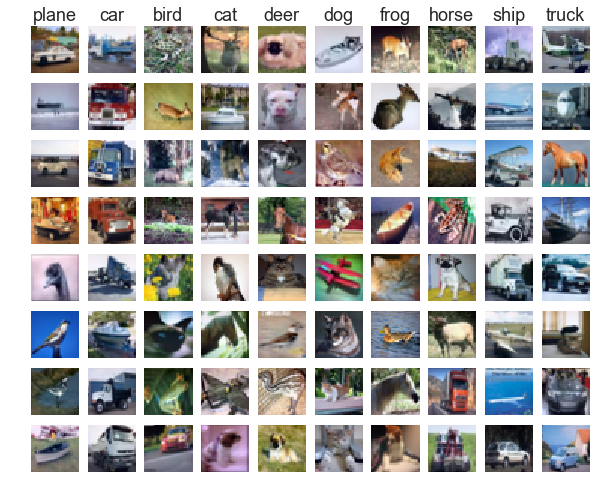

In [41]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

def normalize(img):
    img_max, img_min = np.max(img), np.min(img)
    img = 255.0 *(img - img_min) / (img_max - img_min)
    return img

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for cls, cls_name in enumerate(classes):
    #loop over all classes;
    idxs = np.where((data['y_test'] != cls) & (y_test_pred == cls))[0]
    #case (1) wrong prediction [false positive]
    idxs_2 = np.where((data['y_test'] == cls) & (y_test_pred != cls))[0]
    #case (2) wrong classification [false negative]
    print(cls_name)
    print('--------')
    #precision = true positives(class_{i}) / (true positives + false positives)
    #recall    = true positives(class_{i}) / (true positives + false negatives)
    true_postives  = np.where((data['y_test'] == cls) & (y_test_pred == cls))[0]
    true_negatives = np.where((data['y_test'] != cls) & (y_test_pred != cls))[0]
    
    false_positives = np.where((data['y_test'] != cls) & (y_test_pred == cls))[0]
    false_negatives = np.where((data['y_test'] == cls) & (y_test_pred != cls))[0]
    
    print("Precision = ", len(true_postives) / (len(true_postives) + len(false_positives)))
    print("Recalll   = ", len(true_postives) / (len(true_postives) + len(false_negatives)))
    print('========')
    #find examples where the prediction matches a specific class
    #BUT: the ground truth is for a different class
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    #try and choose '8' examples
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(normalize(data['X_test'][idx]).transpose((1,2,0)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

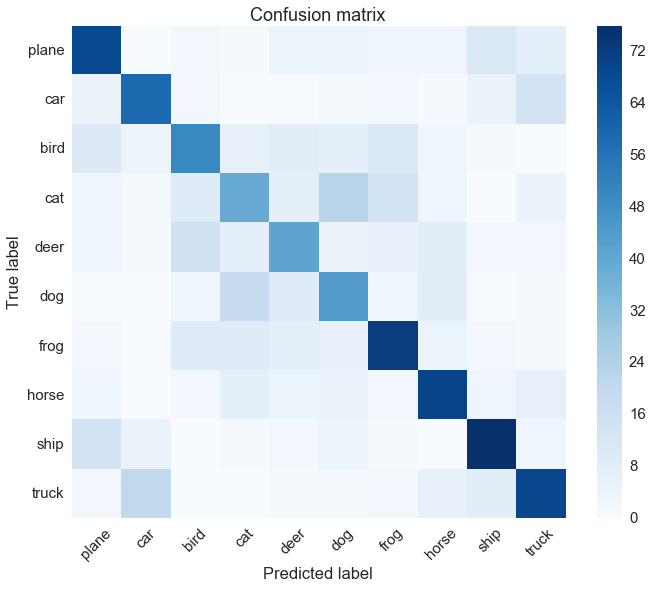

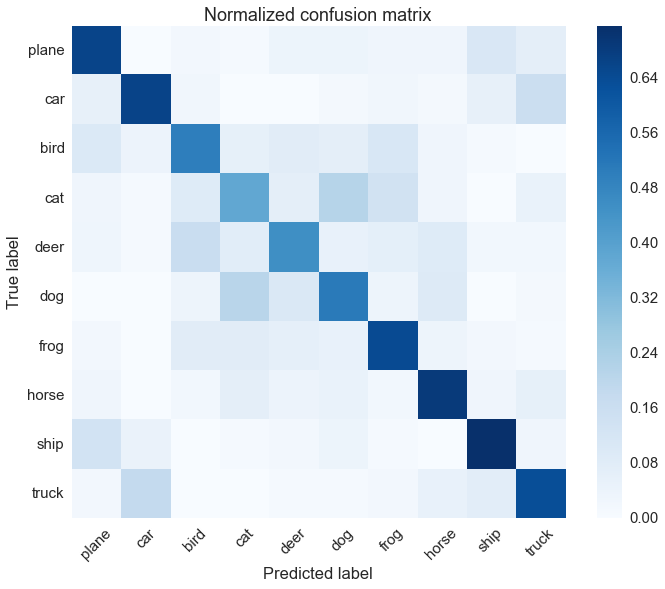

In [44]:
from sklearn.metrics import confusion_matrix

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


y_test = data['y_test'] 
cm = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    if labels is None:
        labels = list(range(len(cm)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.grid(b='off')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, labels=classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title="Normalized confusion matrix", labels=classes)